In [1]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
import warnings
warnings.simplefilter('ignore')
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
import os
from sklearn.preprocessing import StandardScaler
import time
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()
os.listdir('./data')

['PA_201605-2012001更新R7(20200323).xlsx',
 'pred_0997_all.csv',
 'tag盤點表20200323.xlsx',
 'tag盤點表_cleaned.csv',
 'train_cleaned.csv',
 'train_preprocessed']

In [2]:
tag = pd.read_csv('./data/tag盤點表_cleaned.csv',index_col=0)
tag = tag.loc[tag.category=='可控制因子']

# load X,y

In [3]:
data = joblib.load('./data/train_preprocessed')
X = data['X']
Y = data['Y']
x_col = data['x_col']
y_col = data['y_col']
idx = data['idx']
# build df
df = pd.DataFrame(X,index=idx)
df['0997_real'] = Y
print(df.shape)
df.head()

(134869, 547)


,0,1,2,3,4,5,6,7,8,9,...,537,538,539,540,541,542,543,544,545,0997_real
2016-06-01 02:40:00,5695.2363,85.352490,36.090110,34.696857,49.382782,362.26434,144.97864,2.442607,361.02557,60.061237,...,362.18622,144.94327,2.347922,361.01324,60.350594,184.75967,180.01015,364.79498,179.32439,6467.7600
2016-06-01 02:50:00,5709.7036,85.653360,35.959490,35.388890,49.400085,362.33936,144.83496,2.486111,361.09380,60.353172,...,362.19500,145.05249,2.342792,361.01670,60.989777,184.67749,180.01030,364.68997,181.94745,6450.8740
2016-06-01 03:00:00,5687.0700,85.301930,36.018215,34.879738,49.394993,362.22006,145.24248,2.369419,361.02510,61.337530,...,362.24260,144.96265,2.392348,361.03952,60.260216,184.69803,179.80000,364.90765,182.75210,6443.6900
2016-06-01 03:10:00,5689.3900,85.273994,35.984818,35.051820,49.394978,362.19617,145.12143,2.425157,360.96103,60.153100,...,362.23618,144.99008,2.396329,361.01053,60.237118,184.61932,180.03043,364.81244,180.19040,6430.3833
2016-06-01 03:20:00,5695.1797,85.347840,36.002686,34.899242,49.394980,362.21060,144.92728,2.340548,361.02005,60.312088,...,362.24550,145.02303,2.359308,361.05435,60.822850,184.64757,179.91011,364.80770,181.87064,6446.3940


# time_step num_sensor

In [4]:
num_sensor = len(x_col)
time_step = int(X.shape[1]/len(x_col))
print(time_step,num_sensor)

39 14


# select data range

In [5]:
df = df.loc['2016-06-20':'2017-02-20']
idx = df.index
df.head(3).append(df.tail(3))

,0,1,2,3,4,5,6,7,8,9,...,537,538,539,540,541,542,543,544,545,0997_real
2016-06-20 00:00:00,7116.3180,85.148020,35.955723,35.209538,49.485020,355.62590,145.03008,2.790372,354.24045,60.712350,...,355.52545,145.00943,2.644965,354.20547,60.619260,184.06555,176.28226,358.51508,182.41208,7904.0625
2016-06-20 00:10:00,7128.8555,85.397430,36.091790,34.759377,49.489960,355.57956,145.01405,2.794634,354.19500,60.305283,...,355.51508,144.95656,2.569579,354.21500,60.278030,184.14162,176.13545,358.69263,181.79498,7913.4487
2016-06-20 00:20:00,7128.2476,85.294334,36.039870,35.170166,49.489960,355.58040,144.97540,2.774529,354.19543,60.403633,...,355.61456,144.98909,2.690484,354.27950,60.554530,184.01282,176.40000,358.52423,178.33656,7911.7050
2017-02-17 06:00:00,7318.1200,76.992160,36.130260,35.061035,49.505020,346.96830,146.49484,1.646714,346.12830,60.520720,...,346.95000,146.57059,1.660524,346.11940,60.531060,181.40356,171.90000,351.18213,177.66031,8041.7900
2017-02-17 06:10:00,7315.9420,76.972176,36.005604,34.951060,49.490055,346.96457,146.42587,1.624964,346.14395,60.758606,...,346.66315,146.53949,1.471631,345.91745,60.654694,181.55270,171.80660,351.08212,174.84160,8039.3890
2017-02-17 06:20:00,7306.1675,76.976906,35.855827,34.771680,49.489944,346.97110,146.52061,1.665420,346.13565,60.293194,...,345.78055,146.76909,0.466979,345.54070,60.545030,182.09363,171.79341,350.99005,178.14595,8021.1885


# split train test

In [6]:
X = df.iloc[:,:-1]
Y = df.iloc[:,-1:]

In [7]:
sp1 = int(len(X)*0.7)
sp2 = int(len(X)*0.85)
X_train,X_valid,X_test = X[:sp1],X[sp1:sp2],X[sp2:]
Y_train,Y_valid,Y_test = Y[:sp1],Y[sp1:sp2],Y[sp2:]
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(22339, 546)
(22339, 1)
(4787, 546)
(4787, 1)
(4788, 546)
(4788, 1)


# plot

In [8]:
t1 = df.iloc[[sp1]].index[0]
t2 = df.iloc[[sp2]].index[0]

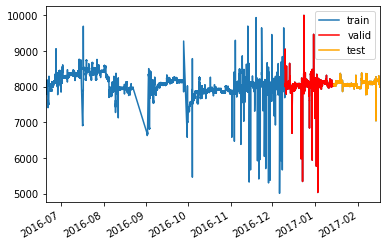

In [9]:
df['0997_real'].plot(label='train')
df['0997_real'][(df.index > t1)&(df.index < t2)].plot(color = 'red',label='valid')
df['0997_real'][(df.index > t2)].plot(color = 'orange',label='test')
plt.legend()
plt.show()

# MinMaxScaler

In [10]:
from sklearn.preprocessing import MinMaxScaler
mm_x = MinMaxScaler().fit(X)
mm_y = MinMaxScaler().fit(Y)

In [11]:
joblib.dump(mm_x,'./model/mm_x.pkl')
joblib.dump(mm_y,'./model/mm_y.pkl')
print('save done!')

save done!


# scale 

In [12]:
X_train = mm_x.transform(X_train)
X_valid = mm_x.transform(X_valid)
X_test = mm_x.transform(X_test)

Y_train = mm_y.transform(Y_train)
Y_valid = mm_y.transform(Y_valid)
Y_test = mm_y.transform(Y_test)

# torch tensor

In [13]:
import torch

X_train = torch.tensor(X_train).cuda()
X_test = torch.tensor(X_test).cuda()

X_valid = torch.tensor(X_valid).cuda()
Y_valid = torch.tensor(Y_valid).cuda()

Y_train = torch.tensor(Y_train).cuda()
Y_test = torch.tensor(Y_test).cuda()

In [14]:
print(X_train.shape,X_valid.shape,X_test.shape)

torch.Size([22339, 546]) torch.Size([4787, 546]) torch.Size([4788, 546])


# data_iter

In [15]:
train = torch.utils.data.TensorDataset(X_train, Y_train)
valid = torch.utils.data.TensorDataset(X_valid, Y_valid)
train_iter = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
valid_iter = torch.utils.data.DataLoader(valid, batch_size=256, shuffle=True)

# Construct the neural network

In [16]:
flat_size = X_train.shape[1]
flat_size,time_step,num_sensor

(546, 39, 14)

In [17]:
class panet(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Sequential(nn.Linear(flat_size,128),
                               nn.Sigmoid(),
                               nn.Linear(128,time_step))
        
        self.b = nn.Sequential(nn.Linear(flat_size,128),
                               nn.Sigmoid(),
                               nn.Linear(128,1))
        
        self.p = nn.Linear(1,1,bias=False)
        self.history_weight = []
        self.history_b = []
        
    def forward(self,x):
        W = F.softmax(self.w(x)**2,dim=1)
        b = self.b(x)
        feed,factor = self.fetch(x)
        WX = torch.sum(feed*W,dim=1).view(-1,1)
        output = self.p(WX) + b
        self.history_weight.append(W)
        self.history_b.append(b)
        return F.sigmoid(output)
        
    def fetch(self,x):
        x_resize = x.view(-1,time_step,num_sensor)
        feed = x_resize[:,:,0]
        factor = x_resize[:,:,1:]
        factor = factor.reshape(-1,time_step*(num_sensor-1))
        return feed,factor 

In [18]:
def init_weights(m):
    if hasattr(m,'weight'):
        try:
            torch.nn.init.xavier_uniform(m.weight)
        except:
            pass
    if hasattr(m,'bias'):
        try:
            m.bias.data.fill_(0)
        except:
            pass

In [19]:
net = panet().cuda().double()
net.apply(init_weights)

panet(
  (w): Sequential(
    (0): Linear(in_features=546, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=39, bias=True)
  )
  (b): Sequential(
    (0): Linear(in_features=546, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (p): Linear(in_features=1, out_features=1, bias=False)
)

In [20]:
net(X_test)

tensor([[0.4994],
        [0.4966],
        [0.4954],
        ...,
        [0.4994],
        [0.4958],
        [0.4946]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SigmoidBackward>)

# tensorboard

In [21]:
with SummaryWriter(comment='Net')as w:
    w.add_graph(net, (X_test,))

# torchviz

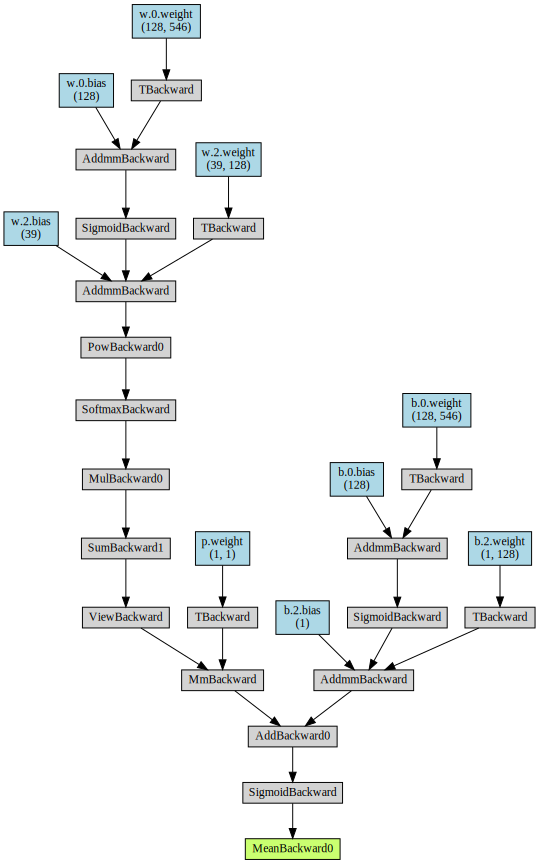

In [22]:
torchviz.make_dot(net(X_test).mean(),params=dict(net.named_parameters()))

# loss_function and optimizer

In [23]:
optimizer = torch.optim.Adam(net.parameters(),lr=1e-4)
loss_function = nn.MSELoss()

# Training and evaluation

In [24]:
def train(net,train_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    for epoch in range(num_epochs): 
        
        # train model
        net.train()
        train_loss,i = 0,0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
            i += 1
        
        # eval model
        with torch.no_grad():
            net.eval()
            val_loss,j = 0,0
            for x, y in valid_iter:
                loss = loss_function(net(x),y)
                val_loss += loss.item()
                j += 1
        
        # caculate avg loss
        train_avg_loss = train_loss/i
        val_avg_loss = val_loss/j
        
        # save the best model
        if val_avg_loss <= best_loss:
            best_loss = val_avg_loss
            joblib.dump(net,'./model/net.pkl')
            print('model saved')
        
        # record history and print loss of the epoch
        train_history.append(train_avg_loss)
        valid_history.append(val_avg_loss)
        print("epochs {} train_avg_loss {:.4f} valid_avg_loss {:.4f}".format(epoch,train_avg_loss,val_avg_loss))
        
    # plot result
    print('best val_avg_loss is ',best_loss)
    fig = plt.figure(figsize=(20,5))
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.legend()
    plt.title('loss')
    plt.show()
    print('model save at ./model/net.pkl')

model saved
epochs 0 train_avg_loss 0.0022 valid_avg_loss 0.0010
model saved
epochs 1 train_avg_loss 0.0015 valid_avg_loss 0.0008
epochs 2 train_avg_loss 0.0013 valid_avg_loss 0.0008
model saved
epochs 3 train_avg_loss 0.0012 valid_avg_loss 0.0008
epochs 4 train_avg_loss 0.0011 valid_avg_loss 0.0009
epochs 5 train_avg_loss 0.0011 valid_avg_loss 0.0008
epochs 6 train_avg_loss 0.0011 valid_avg_loss 0.0009
epochs 7 train_avg_loss 0.0011 valid_avg_loss 0.0009
model saved
epochs 8 train_avg_loss 0.0011 valid_avg_loss 0.0008
epochs 9 train_avg_loss 0.0011 valid_avg_loss 0.0009
model saved
epochs 10 train_avg_loss 0.0011 valid_avg_loss 0.0008
epochs 11 train_avg_loss 0.0011 valid_avg_loss 0.0008
epochs 12 train_avg_loss 0.0011 valid_avg_loss 0.0008
epochs 13 train_avg_loss 0.0011 valid_avg_loss 0.0009
epochs 14 train_avg_loss 0.0011 valid_avg_loss 0.0009
epochs 15 train_avg_loss 0.0011 valid_avg_loss 0.0009
epochs 16 train_avg_loss 0.0011 valid_avg_loss 0.0009
epochs 17 train_avg_loss 0.0011 

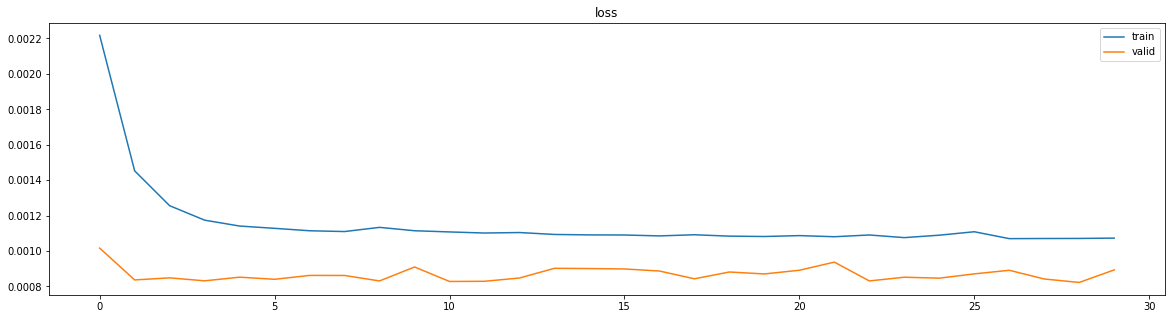

model save at ./model/net.pkl
54.97016215324402


In [25]:
s = time.time()
train(net,train_iter,loss_function,optimizer,num_epochs=30)
print(time.time()-s)

# load best net

In [26]:
net = joblib.load('./model/net.pkl')
net = net.eval()
net

panet(
  (w): Sequential(
    (0): Linear(in_features=546, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=39, bias=True)
  )
  (b): Sequential(
    (0): Linear(in_features=546, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (p): Linear(in_features=1, out_features=1, bias=False)
)

In [27]:
temp = pd.DataFrame(net.history_weight[-1].detach().cpu().numpy()[0]).T
temp.columns = ['t-'+str(temp.shape[1]-i)for i in range(temp.shape[1])]
temp.style.background_gradient(axis=1)

,t-39,t-38,t-37,t-36,t-35,t-34,t-33,t-32,t-31,t-30,t-29,t-28,t-27,t-26,t-25,t-24,t-23,t-22,t-21,t-20,t-19,t-18,t-17,t-16,t-15,t-14,t-13,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
0,6.66903e-08,1.91638e-07,7.6938e-07,0.949693,8.44032e-08,1.24888e-07,4.13937e-07,1.04861e-07,8.72244e-08,7.06197e-08,1.84492e-07,6.8385e-08,6.96539e-08,6.73333e-08,1.52126e-07,2.0122e-07,3.71613e-07,6.66398e-08,1.2878e-07,6.94973e-08,7.54927e-08,7.28124e-08,7.18901e-08,9.96179e-08,8.50547e-08,6.66122e-08,1.13885e-07,7.58017e-08,6.66592e-08,6.89412e-08,6.76561e-08,1.37799e-07,6.66547e-08,7.37975e-08,8.16073e-08,0.0503016,3.263e-07,8.5641e-08,6.66535e-08


In [28]:
net.p.weight.data

tensor([[0.5687]], device='cuda:0', dtype=torch.float64)

In [29]:
net.history_b[-1].detach().cpu().numpy().mean()

-0.01655737419436886

# metrics

In [30]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from math import sqrt

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100


feed = X.values.reshape(-1,time_step,num_sensor).mean(axis=1)
feed = pd.DataFrame(feed,columns=x_col,index=idx)
feed = feed['MLPAP_FQ-0619.PV']

def show_result(X,Y,index,tag):
    t = pd.DataFrame(index=index)
    t['0619'] = feed[index]
    t['0997_real'] = mm_y.inverse_transform(Y.detach().cpu().numpy().reshape(-1,1)).ravel()
    t['0997_pred'] = mm_y.inverse_transform(net(X).detach().cpu().numpy().reshape(-1,1)).ravel()
    t['單耗_real'] = t['0619']/t['0997_real']
    t['單耗_pred'] = t['0619']/t['0997_pred']
    #t['0997_R2'] = r2_score(t['0997_real'],t['0997_pred'])
    #t['0997_MAPE'] = mape(t['0997_real'],t['0997_pred'])
    t['單耗RMSE'] = sqrt(mean_squared_error(t['單耗_real'],t['單耗_pred']))
    t['單耗MAPE'] = mape(t['單耗_real'],t['單耗_pred'])
    m = t.iloc[[0],-2:]
    m.index = [tag]
    t = t.iloc[:,:-2]
    return t,m

# make prediction(train)

In [31]:
t1,m1 = show_result(X_train,Y_train,idx[:sp1],'train')
m1.head()

,單耗RMSE,單耗MAPE
train,0.020757,1.214134


In [32]:
t1.head()

,0619,0997_real,0997_pred,單耗_real,單耗_pred
2016-06-20 00:00:00,7121.605462,7904.0625,7760.167343,0.901006,0.917713
2016-06-20 00:10:00,7121.600718,7913.4487,7755.199422,0.899936,0.918300
2016-06-20 00:20:00,7121.406505,7911.7050,7760.804536,0.900110,0.917612
2016-06-20 00:30:00,7120.891579,7896.0980,7771.228252,0.901824,0.916315
2016-06-20 00:40:00,7120.652221,7889.9550,7756.965673,0.902496,0.917969


# make prediction(valid)

In [33]:
t2,m2 = show_result(X_valid,Y_valid,idx[sp1:sp2],'valid')
m2.head()

,單耗RMSE,單耗MAPE
valid,0.018973,0.904659


In [34]:
t2.head()

,0619,0997_real,0997_pred,單耗_real,單耗_pred
2016-12-10 07:10:00,7283.197213,8307.570,8035.108710,0.876694,0.906422
2016-12-10 07:20:00,7283.186315,8512.873,8049.507852,0.855550,0.904799
2016-12-10 07:30:00,7283.296513,8637.871,8034.164055,0.843182,0.906541
2016-12-10 07:40:00,7283.443010,8869.349,8053.464217,0.821193,0.904386
2016-12-10 07:50:00,7283.433077,9054.413,8041.608115,0.804407,0.905718


# make prediction(test)

In [35]:
t3,m3 = show_result(X_test,Y_test,idx[sp2:],'test')
m3.head()

,單耗RMSE,單耗MAPE
test,0.007673,0.620494


In [36]:
t3.head()

,0619,0997_real,0997_pred,單耗_real,單耗_pred
2017-01-14 17:50:00,7243.250277,8055.5244,8063.872206,0.899166,0.898235
2017-01-14 18:00:00,7242.868669,8024.5176,8057.360714,0.902592,0.898913
2017-01-14 18:10:00,7242.386949,8017.8600,8059.675641,0.903282,0.898595
2017-01-14 18:20:00,7241.894649,8023.5750,8063.633915,0.902577,0.898093
2017-01-14 18:30:00,7241.352554,8044.7230,8061.346977,0.900137,0.898281


In [37]:
pred_0997_all = t1.append(t2).append(t3)['0997_pred']
pred_0997_all.head()

2016-06-20 00:00:00    7760.167343
2016-06-20 00:10:00    7755.199422
2016-06-20 00:20:00    7760.804536
2016-06-20 00:30:00    7771.228252
2016-06-20 00:40:00    7756.965673
Name: 0997_pred, dtype: float64

In [38]:
pred_0997_all.to_csv('./data/pred_0997_all.csv')
print('save done')

save done
